# Demo: GPTQ ≈ Babai quantization


In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent / "src"))

import numpy as np
import matplotlib.pyplot as plt
from gptq_babai.core import gptq_babai_quantize
from gptq_babai.lattice_utils import cholesky_factor

# Génération toy


In [ ]:
np.random.seed(0)
d = 3
w = np.random.randn(d)
H = np.random.randn(d, d)
H = H.T @ H + np.eye(d) * 1e-2  # SPD
q_levels = np.arange(-8, 9)  # simulate 4-bit


# Quantification


In [ ]:
w_hat = gptq_babai_quantize(w, H, q_levels, clip=False)


# Visualisation


In [ ]:
def plot_vector_projection(w, w_hat):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver(0, 0, 0, *w, color='blue', label='Original w')
    ax.quiver(0, 0, 0, *w_hat, color='red', label='Quantized w_hat')
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_zlim([-2, 2])
    ax.legend()
    plt.title('GPTQ ≈ Babai Projection')
    plt.show()

plot_vector_projection(w, w_hat)

# Erreur quadratique pondérée


In [ ]:
error = (w - w_hat).T @ H @ (w - w_hat)
print(f"Weighted quantization error: {error:.6f}")

In [ ]:
from transformers import AutoModelForCausalLM
from gptq_babai.hf_quant import quantize_linear_layer

model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen1.5-0.5B")
proj = model.transformer.h[0].attn.c_proj  # Linear

# Approximation dummy (ex: diag)
W = proj.weight.detach().cpu().numpy()
H_dummy = np.cov(W, rowvar=False) + np.eye(W.shape[1]) * 1e-3

W_quant = quantize_linear_layer(proj, H_dummy, q_bits=4, block_size=128)
proj.weight.data = W_quant.to(proj.weight.device)


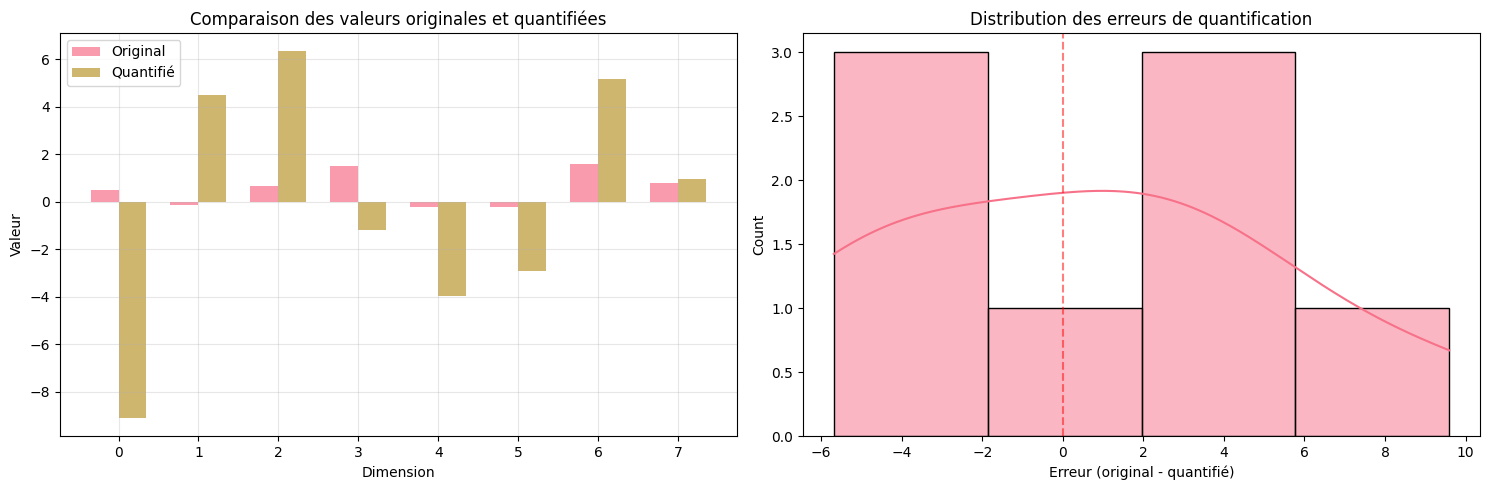

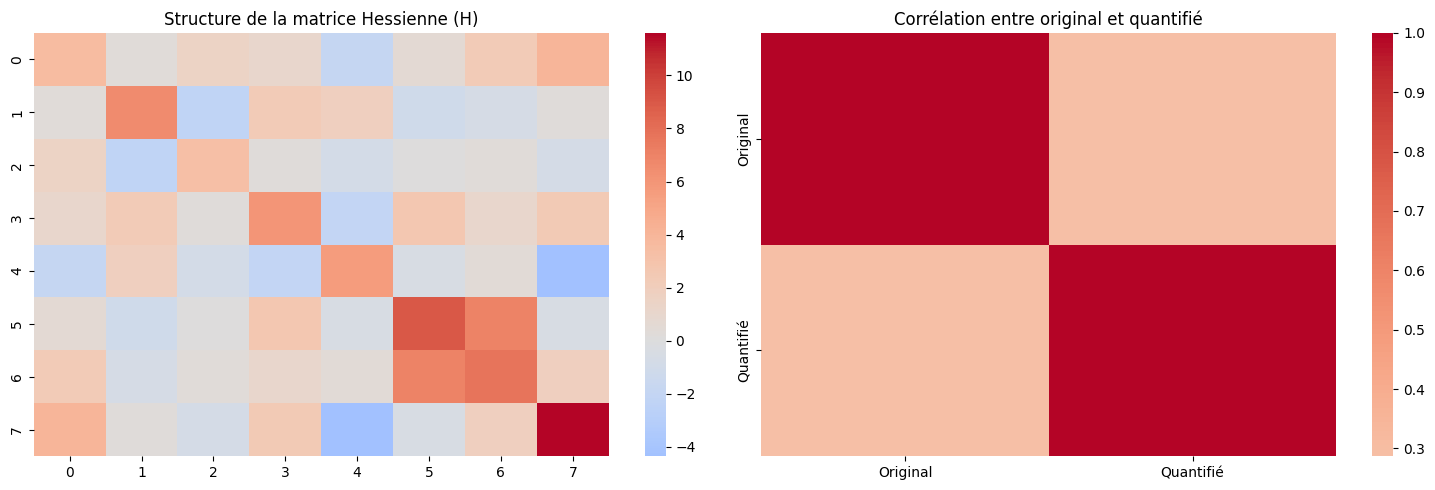

Métriques de quantification:
MSE: 23.411439
Erreur pondérée: 84.588756
Erreur max: 9.594110
Taux de compression: 8.0x


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from gptq_babai.core import gptq_babai_quantize
from gptq_babai.lattice_utils import cholesky_factor
import seaborn as sns

# Configuration de style pour de plus beaux graphiques
# plt.style.use('interactive')
sns.set_palette("husl")

# Génération de données plus intéressantes
np.random.seed(42)
d = 8  # dimension plus grande pour mieux voir les effets
w = np.random.randn(d)
# Création d'une matrice de covariance plus intéressante
H = np.random.randn(d, d)
H = H.T @ H + np.eye(d) * 1e-2  # SPD avec structure

# Niveaux de quantification (4-bit symmetric)
q_levels = np.linspace(-8, 8, 16)

# Quantification
w_hat = gptq_babai_quantize(w, H, q_levels, clip=True)

# Visualisations

def plot_quantization_comparison(w, w_hat, q_levels):
    """Plot détaillé de la comparaison entre valeurs originales et quantifiées"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Comparaison directe
    indices = np.arange(len(w))
    width = 0.35
    ax1.bar(indices - width/2, w, width, label='Original', alpha=0.7)
    ax1.bar(indices + width/2, w_hat, width, label='Quantifié', alpha=0.7)
    ax1.set_xlabel('Dimension')
    ax1.set_ylabel('Valeur')
    ax1.set_title('Comparaison des valeurs originales et quantifiées')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Distribution des erreurs
    errors = w - w_hat
    sns.histplot(errors, kde=True, ax=ax2)
    ax2.axvline(x=0, color='r', linestyle='--', alpha=0.5)
    ax2.set_title('Distribution des erreurs de quantification')
    ax2.set_xlabel('Erreur (original - quantifié)')
    
    plt.tight_layout()
    return fig

def plot_heatmap_analysis(w, w_hat, H):
    """Analyse détaillée avec heatmaps"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Heatmap de la matrice H
    sns.heatmap(H, ax=ax1, cmap='coolwarm', center=0)
    ax1.set_title('Structure de la matrice Hessienne (H)')
    
    # Plot 2: Analyse des corrélations
    corr = np.corrcoef(np.vstack([w, w_hat]))
    sns.heatmap(corr, ax=ax2, cmap='coolwarm', center=0,
                xticklabels=['Original', 'Quantifié'],
                yticklabels=['Original', 'Quantifié'])
    ax2.set_title('Corrélation entre original et quantifié')
    
    plt.tight_layout()
    return fig

# Affichage des métriques
def print_quantization_metrics(w, w_hat, H):
    """Calcul et affichage des métriques de quantification"""
    mse = np.mean((w - w_hat) ** 2)
    weighted_error = (w - w_hat).T @ H @ (w - w_hat)
    max_error = np.max(np.abs(w - w_hat))
    
    print(f"Métriques de quantification:")
    print(f"{'='*40}")
    print(f"MSE: {mse:.6f}")
    print(f"Erreur pondérée: {weighted_error:.6f}")
    print(f"Erreur max: {max_error:.6f}")
    print(f"Taux de compression: {32/np.log2(len(q_levels)):.1f}x")

# Affichage des résultats
plot_quantization_comparison(w, w_hat, q_levels)
plt.show()

plot_heatmap_analysis(w, w_hat, H)
plt.show()

print_quantization_metrics(w, w_hat, H)